# OECD/SWAC Urban Green Space and tree cover estimation approach
* **Products used:** 
[esa_worldcover_2020](https://explorer.digitalearth.africa/products/esa_worldcover_2020), [esa_worldcover_2021](https://explorer.digitalearth.africa/products/esa_worldcover_2021)

### Background
This notebook shows the [Sahel and West Africa Club's](https://www.oecd.org/swac/) (SWAC, OECD) approach to estimating urban green space and tree cover indicators within African urban agglomerations. Urban green spaces enhance a city's resilience to climate change and sustainability by mitigating extreme weather and gradual threats like drought and erosion. They reduce air pollution, sequester carbon, improve water quality, and support biodiversity and people's physical and mental health. A [SWAC analysis](https://www.oecd-ilibrary.org/development/boosting-african-cities-resilience-to-climate-change_3303cfb3-en) highlights these benefits for African cities and uncovers interesting continental trends.


The OECD/SWAC created the [Africapolis dataset](https://docs.digitalearthafrica.org/en/latest/data_specs/Africapolis_urban_specs.html) to provide a much needed standardised and geospatial database on urbanisation dynamics in Africa, with the aim of making urban data in Africa comparable across countries and across time. Africapolis data is based on a large inventory of housing and population censuses, electoral registers and other official population sources, in some cases dating back to the beginning of the 20th century. 

These datasets (``africapolis_2015`` and ``africapolis_2020``) are shared with indicators or urban green space, i.e., the percentage of the urban agglomeration area that has green cover (trees, shrubs, and grass), as well as the percentage of tree cover. These indicators were estimated using the land cover information from the [ESA World Cover v100 (2020)]("https://worldcover2020.esa.int/") and [ESA World Cover v200 (2021)]("https://worldcover2021.esa.int/"). The [ESA World Cover](https://esa-worldcover.org/) dataset offers information on land cover types, allowing for the calculation of land cover fractions such as **urban green space**, built-up areas, open land, and open water. Zonal statistics are used to derive frequency histograms of land cover classes within each agglomeration, which are then processed to calculate these indicators. **Urban green space** is calculated as the sum of the area of the classes *tree cover*, *shrubland*, and *grassland* divided by the total area of the urban agglomeration. The tree cover percentage is specifically based on the area of the tree cover class divided by the total area of the agglomeration. See the [Mapping Territorial Transformations in Africa](https://www.mapping-africa-transformations.org/climate/) platform for more information and insights derived from this indicator.


This notebook demonstrates the methodology used by SWAC to calculate urban green space and tree cover indicators for the Africapolis dataset. It also allows users to replicate this analysis for their own urban agglomerations that are not part of the Africapolis dataset. If you would like to check whether a specific agglomeration is already included in the Africapolis dataset, refer to the [Africapolis_urban_agglomerations](../Datasets/Africapolis_urban_agglomerations.ipynb) notebook.



#### Reference
Anderson, B., J.E. Patiño Quinchia, R. Prieto-Curiel (2022), “Boosting African cities’ resilience to climate change: The role of green spaces”, West African Papers, No. 37, OECD Publishing, Paris. https://doi.org/1787/3303cfb3-en 

### Description
This notebook is designed to derive urban green space metrics in African urban spaces. It follows these steps
1. Select/load a location for the analysis.
2. Calculate the frequency of land cover occurrence in each urban agglomeration of interest.
3. Calculate land cover fractions and aggregate into categories (i.e., green space, tree cover).

### Load packages
Import Python packages that are used for the analysis.

In [1]:
import datacube
import rasterio
import numpy as np
import pandas as pd
import geopandas as gpd

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from datacube.utils import geometry
from odc.dscache.tools import tiling
from shapely.geometry import Polygon, shape
from datacube.utils.geometry import Geometry

from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.areaofinterest import define_area
from deafrica_tools.plotting import display_map, plot_lulc

### Connect to the datacube
Connect to the datacube so we can access DE Africa data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app="OECD_SWAC_Urban_green_space")

### Analysis parameters
#### Select location

The following cell sets the parameters, which define the area of interest to conduct the analysis over.
#### Select location
To define the area of interest, there are two methods available:

1. By specifying the latitude, longitude, and buffer, or separate latitude and longitude buffers, this method allows you to define an area of interest around a central point. You can input the central latitude, central longitude, and a buffer value in degrees to create a square area around the center point. For example, `lat = 10.338`, `lon = -1.055`, and `buffer = 0.1` will select an area with a radius of 0.1 square degrees around the point with coordinates `(10.338, -1.055)`. 
    
    Alternatively, you can provide separate buffer values for latitude and longitude for a rectangular area. For example, `lat = 10.338`, `lon = -1.055`, and `lat_buffer = 0.1` and`lon_buffer = 0.08` will select a rectangular area extending 0.1 degrees north and south, and 0.08 degrees east and west from the point `(10.338, -1.055)`.
    
    For reasonable loading times, set the buffer as `0.1` or lower.

2. By uploading a polygon as a `GeoJSON or Esri Shapefile`. If you choose this option, you will need to upload the geojson or ESRI shapefile into the Sandbox using Upload Files button <img align="top" src="../Supplementary_data/upload_files_icon.png"> in the top left corner of the Jupyter Notebook interface. ESRI shapefiles must be uploaded with all the related files `(.cpg, .dbf, .shp, .shx)`. Once uploaded, you can use the shapefile or geojson to define the area of interest. Remember to update the code to call the file you have uploaded.

To use one of these methods, you can uncomment the relevant line of code and comment out the other one. To comment out a line, add the `"#"` symbol before the code you want to comment out. By default, the first option which defines the location using latitude, longitude, and buffer is being used.

In [3]:
# Method 1: Specify the latitude, longitude, and buffer
aoi = define_area(lat=6.6975, lon=-1.6286, buffer=0.2) # Using Kumasi, Ghana as an example similar to the Africapolis_urban_agglomerations notebook.

# Method 2: Use a polygon as a GeoJSON or Esri Shapefile. This can include multiple polygons.
# aoi = define_area(vector_path='aoi.shp')

#Create a geopolygon and geodataframe of the area of interest
geopolygon_list = [Geometry(feature['geometry'], crs="EPSG:4326") for feature in aoi['features']]
agglomeration = gpd.GeoDataFrame(geometry=geopolygon_list, crs="EPSG:4326")
agglomeration['agglosID'] = range(1, len(agglomeration) + 1)

# Get the latitude and longitude range of the geopolygon
lat_range = (agglomeration.total_bounds[1], agglomeration.total_bounds[3])
lon_range = (agglomeration.total_bounds[0], agglomeration.total_bounds[2])
# display_map(x=lon_range, y=lat_range)

agglomeration.explore(tiles="https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",
                attr='http://mt0.google.com/vt/lyrs=y&hl=en&x={x}&y={y}&z={z}')

### Perform zonal statistics using ESA Worldcover (2020 & 2021)
This section of the notebook performs zonal statistics on urban agglomeration polygons using ESA WorldCover data from 2020 and 2021. It processes each polygon individually using a loop, extracting the relevant data for each year, masking the data to the polygon's boundary, and then calculating frequency histograms of land cover classes within that area. These histograms provide insights into the distribution of different land cover types within the agglomeration. The results are stored for further analysis and comparison.

In [4]:
# Define resolution, measurements, and classes
resolution = (-10, 10)
measurements = ['classification']
classes = [10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 100]

# Define the years of interest
years = ['2020', '2021']

# Zonal stats results
zs_results = []

# Iterate over each row in the GeoDataFrame with progress bar
for idx, row in tqdm(agglomeration.iterrows(), total=agglomeration.shape[0]):
    # Define query parameters based on the polygon's geometry
    geom = geometry.Geometry(geom=row['geometry'], crs="EPSG:4326")
    
    # Initialize a dictionary to hold histograms for each year
    yearly_histograms = {}
    
    for year in years:
        # Create a reusable datacube query object
        query = {
            'time': year,  # Select the year of interest
            'geopolygon': geom,
            'resolution': resolution,
            'output_crs': 'EPSG:6933',
            'measurements': measurements
        }
        
        try:
            # Load the ESA data for the current polygon and year
            ds_esa = dc.load(product=f'esa_worldcover_{query["time"]}', **query).squeeze()

            # Rasterize the area of interest polygon
            aoi_raster = xr_rasterize(
                gdf=gpd.GeoDataFrame(geometry=[row['geometry']], crs="EPSG:4326"),
                da=ds_esa,
                crs=ds_esa.crs
            )

            # Mask the dataset to the rasterized area of interest
            ds_esa = ds_esa.where(aoi_raster == 1)

            # Calculate frequency histogram of land cover classes
            lc_array = ds_esa.classification.values.flatten()
            lc_classes, lc_counts = np.unique(lc_array, return_counts=True)
            lc_frequency = dict(zip(lc_classes, lc_counts))

            # Remove last element (NaN) from dictionary if it exists
            lc_frequency.pop(np.nan, None)

            # Store the histogram for the current year
            yearly_histograms[year] = lc_frequency

        except Exception as e:
            # Handle any errors that occur during data loading or processing
            print(f"Error processing polygon {idx} for year {year}: {e}")
            yearly_histograms[year] = {}

    # Append results to zs_results
    zs_results.append({'agglosID': row.agglosID,'geometry': row['geometry'], 'histograms': yearly_histograms})

# Convert results to DataFrame

zs_results_df = pd.DataFrame(zs_results)
print(zs_results_df.head())


  0%|          | 0/1 [00:00<?, ?it/s]

   agglosID                                           geometry  \
0         1  POLYGON ((-1.4286 6.4975, -1.4286 6.8975, -1.8...   

                                          histograms  
0  {'2020': {10.0: 9281028, 20.0: 2103586, 30.0: ...  


### Process histogram data into separate columns and calculate fractions
The ESA WorldCover zonal statistics results are used to calculate the fractions of land cover classes within each polygon. Landcover fractions are calculated by dividing each class count by the total count and the results are ordered and selected for each polygon. 

In [5]:
# Process histograms into separate columns for each year
def process_histogram_per_year(row, year):
    histogram = row['histograms'].get(year, {})
    return pd.Series(histogram)

# Process histograms for both years (2020 and 2021)
histograms_2020_df = zs_results_df.apply(lambda row: process_histogram_per_year(row, '2020'), axis=1).fillna(0).astype(int)
histograms_2021_df = zs_results_df.apply(lambda row: process_histogram_per_year(row, '2021'), axis=1).fillna(0).astype(int)

# Reindex to include all classes (fill missing with 0)
histograms_2020_df = histograms_2020_df.reindex(columns=classes, fill_value=0)
histograms_2021_df = histograms_2021_df.reindex(columns=classes, fill_value=0)

# Rename columns for clarity
histograms_2020_df.rename(columns={k: f'lc_{k}_count_2020' for k in classes}, inplace=True)
histograms_2021_df.rename(columns={k: f'lc_{k}_count_2021' for k in classes}, inplace=True)

# Combine with original DataFrame
zs_ESA_LC = pd.concat([zs_results_df[['agglosID', 'geometry']], histograms_2020_df, histograms_2021_df], axis=1)

# Calculate total counts and fractions for both years
for year in ['2020', '2021']:
    zs_ESA_LC[f'total_count_{year}'] = zs_ESA_LC.filter(like=f'_count_{year}').sum(axis=1)
    for k in classes:
        zs_ESA_LC[f'lc_{k}_fraction_{year}'] = zs_ESA_LC[f'lc_{k}_count_{year}'] / zs_ESA_LC[f'total_count_{year}']

# Multiply fractions by 100 to convert them into percentages
for year in ['2020', '2021']:
    for k in classes:
        zs_ESA_LC[f'lc_{k}_fraction_{year}'] *= 100
        
# Explicitly order the fraction columns for each year
fraction_columns_ordered_2020 = [f"lc_{k}_fraction_2020" for k in classes]
fraction_columns_ordered_2021 = [f"lc_{k}_fraction_2021" for k in classes]

# Combine ordered columns into the final DataFrame
zs_ESA_LC_selected = zs_ESA_LC[['agglosID', 'geometry'] + fraction_columns_ordered_2020 + fraction_columns_ordered_2021].fillna(0).round(5)

# Display the final DataFrame
zs_ESA_LC_selected.head()


# Calculate total counts and fractions for both years
for year in ['2020', '2021']:
    zs_ESA_LC[f'total_count_{year}'] = zs_ESA_LC.filter(like=f'_count_{year}').sum(axis=1)
    for k in classes:
        zs_ESA_LC[f'lc_{k}_fraction_{year}'] = zs_ESA_LC[f'lc_{k}_count_{year}'] / zs_ESA_LC[f'total_count_{year}']

# Multiply fractions by 100 to convert them into percentages
for year in ['2020', '2021']:
    for k in classes:
        zs_ESA_LC[f'lc_{k}_fraction_{year}'] *= 100

# Explicitly order the fraction columns for each year
fraction_columns_ordered_2020 = [f"lc_{k}_fraction_2020" for k in classes]
fraction_columns_ordered_2021 = [f"lc_{k}_fraction_2021" for k in classes]

# Combine ordered columns into the final DataFrame
zs_ESA_LC_selected = zs_ESA_LC[['agglosID', 'geometry'] + fraction_columns_ordered_2020 + fraction_columns_ordered_2021].fillna(0).round(2)

# Display the final DataFrame
zs_ESA_LC_selected.head()


,agglosID,geometry,lc_10_fraction_2020,lc_20_fraction_2020,lc_30_fraction_2020,lc_40_fraction_2020,lc_50_fraction_2020,lc_60_fraction_2020,lc_70_fraction_2020,lc_80_fraction_2020,...,lc_20_fraction_2021,lc_30_fraction_2021,lc_40_fraction_2021,lc_50_fraction_2021,lc_60_fraction_2021,lc_70_fraction_2021,lc_80_fraction_2021,lc_90_fraction_2021,lc_95_fraction_2021,lc_100_fraction_2021
0,1,"POLYGON ((-1.4286 6.4975, -1.4286 6.8975, -1.8...",23.72,5.38,6.3,0.14,9.86,4.43,0.0,0.16,...,3.2,7.67,0.01,13.04,0.2,0.0,0.17,0.01,0.0,0.0


#### Land cover fraction comparison for 2020 and 2021
We compare the land cover fractions for different classes between 2020 and 2021. Each agglomeration is analyzed, and the fractions of these land cover types are calculated for both years.

The bar chart below displays the comparison of these fractions for each agglomeration, with bars for 2020 shown in sky blue and bars for 2021 shown in salmon. The plot provides a visual representation of how the land cover has shifted between the two years, highlighting any notable changes in land use or environmental trends.

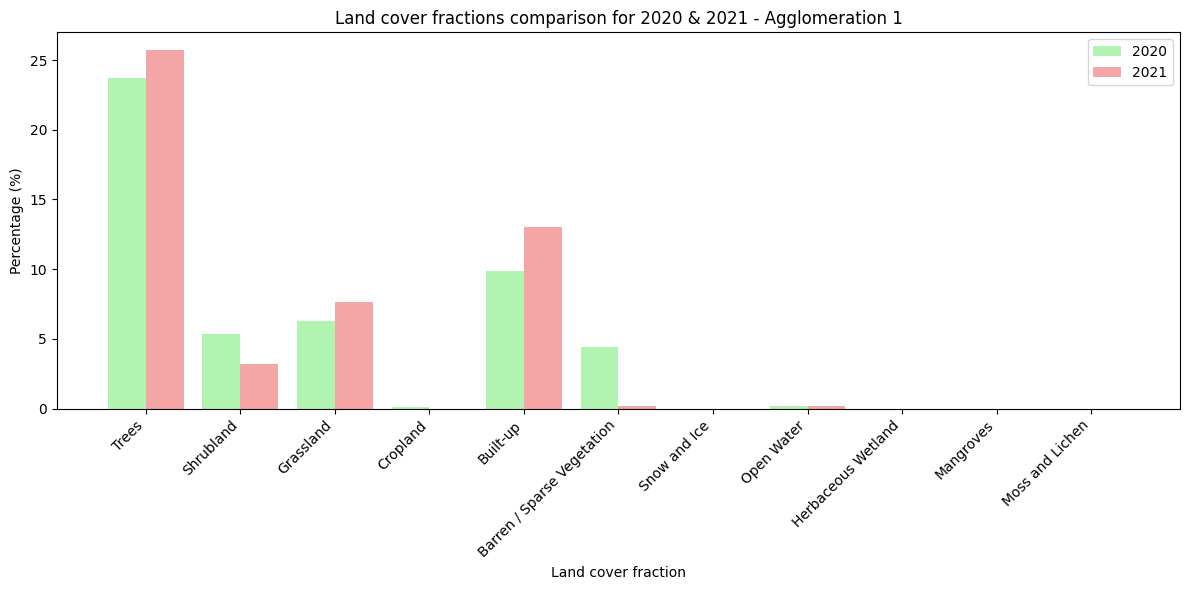

In [6]:
# List of land cover class names for the x-axis
land_cover_labels = [
    "Trees",     # lc_10_fraction
    "Shrubland", # lc_20_fraction
    "Grassland", # lc_30_fraction
    "Cropland",  # lc_40_fraction
    "Built-up",  # lc_50_fraction
    "Barren / Sparse Vegetation", # lc_60_fraction
    "Snow and Ice", # lc_70_fraction
    "Open Water", # lc_80_fraction
    "Herbaceous Wetland", # lc_90_fraction
    "Mangroves",  # lc_95_fraction
    "Moss and Lichen", # lc_100_fraction
]

# Bar width and x-axis positions
bar_width = 0.4  # width of each bar
index = np.arange(len(land_cover_labels))  # positions for the bars on the x-axis

# Iterate through the rows in the final DataFrame and plot histograms
for idx, row in zs_ESA_LC_selected.iterrows():
    agglosID = row['agglosID']
    
    # Extract the counts for 2020 and 2021
    lc_counts_2020 = [row[f'lc_{k}_fraction_2020'] for k in classes]
    lc_counts_2021 = [row[f'lc_{k}_fraction_2021'] for k in classes]

    # Create a figure for the combined plot
    plt.figure(figsize=(12, 6))

    # Plot for 2020 (shifted to the left)
    plt.bar(index - bar_width / 2, lc_counts_2020, bar_width, alpha=0.7, color='lightgreen', label='2020')

    # Plot for 2021 (shifted to the right)
    plt.bar(index + bar_width / 2, lc_counts_2021, bar_width, alpha=0.7, color='lightcoral', label='2021')

    # Add titles and labels
    plt.title(f'Land cover fractions comparison for 2020 & 2021 - Agglomeration {agglosID}')
    plt.xlabel('Land cover fraction')
    plt.ylabel('Percentage (%)')
    plt.xticks(index, land_cover_labels, rotation=45, ha='right') 
    plt.legend()

    # Display the plot
    plt.tight_layout()
    plt.show()


### Calculate green space and tree cover indicators
Calculate proxies for green space and tree cover based on the fractions of specific land cover classes. The Urban Green Space indicator is derived by summing the fractions of land cover types associated with vegetation (i.e., Trees, Shrubland, and Grassland) for both 2020 and 2021. The Tree Cover indicator focuses specifically on the fraction of land covered by trees. These indicators are calculated for each agglomeration and are expressed as percentages to facilitate comparison across different urban areas. 

In [7]:
# Calculate specific fractions for 2020 and convert to percentages
zs_ESA_LC['p_Tree_cover_WC2020'] = (zs_ESA_LC['lc_10_fraction_2020']).round(1)
zs_ESA_LC['p_Urban_green_space_WC2020'] = (zs_ESA_LC[['lc_10_fraction_2020', 'lc_20_fraction_2020', 'lc_30_fraction_2020']].sum(axis=1)).round(1)

# Calculate specific fractions for 2021 and convert to percentages
zs_ESA_LC['p_Tree_cover_WC2021'] = (zs_ESA_LC['lc_10_fraction_2021']).round(1)
zs_ESA_LC['p_Urban_green_space_WC2021'] = (zs_ESA_LC[['lc_10_fraction_2021', 'lc_20_fraction_2021', 'lc_30_fraction_2021']].sum(axis=1)).round(1)

# Select and rename columns
green_space_indicators = zs_ESA_LC[['agglosID', 
                             'p_Urban_green_space_WC2020', 'p_Tree_cover_WC2020', 
                             'p_Urban_green_space_WC2021', 'p_Tree_cover_WC2021', 'geometry']].copy()

# Convert the resulting DataFrame into a GeoDataFrame to handle spatial data, setting the geometry column appropriately and defining the CRS as "EPSG:4326"
green_space_indicators = gpd.GeoDataFrame(green_space_indicators, geometry='geometry', crs="EPSG:4326")
# Display final DataFrame
green_space_indicators.head()


,agglosID,p_Urban_green_space_WC2020,p_Tree_cover_WC2020,p_Urban_green_space_WC2021,p_Tree_cover_WC2021,geometry
0,1,35.4,23.7,36.6,25.7,"POLYGON ((-1.42860 6.49750, -1.42860 6.89750, ..."


#### Visualise urban green space and tree cover indicators
Visualize the comparison of urban green space and tree cover between 2020 and 2021 for each selected agglomeration. The visualizations include a map displaying the agglomeration boundaries, stacked maps of ESA WorldCover classifications for both years to show land cover changes, and a grouped bar chart that compares the percentage of urban green space and tree cover in the two years.

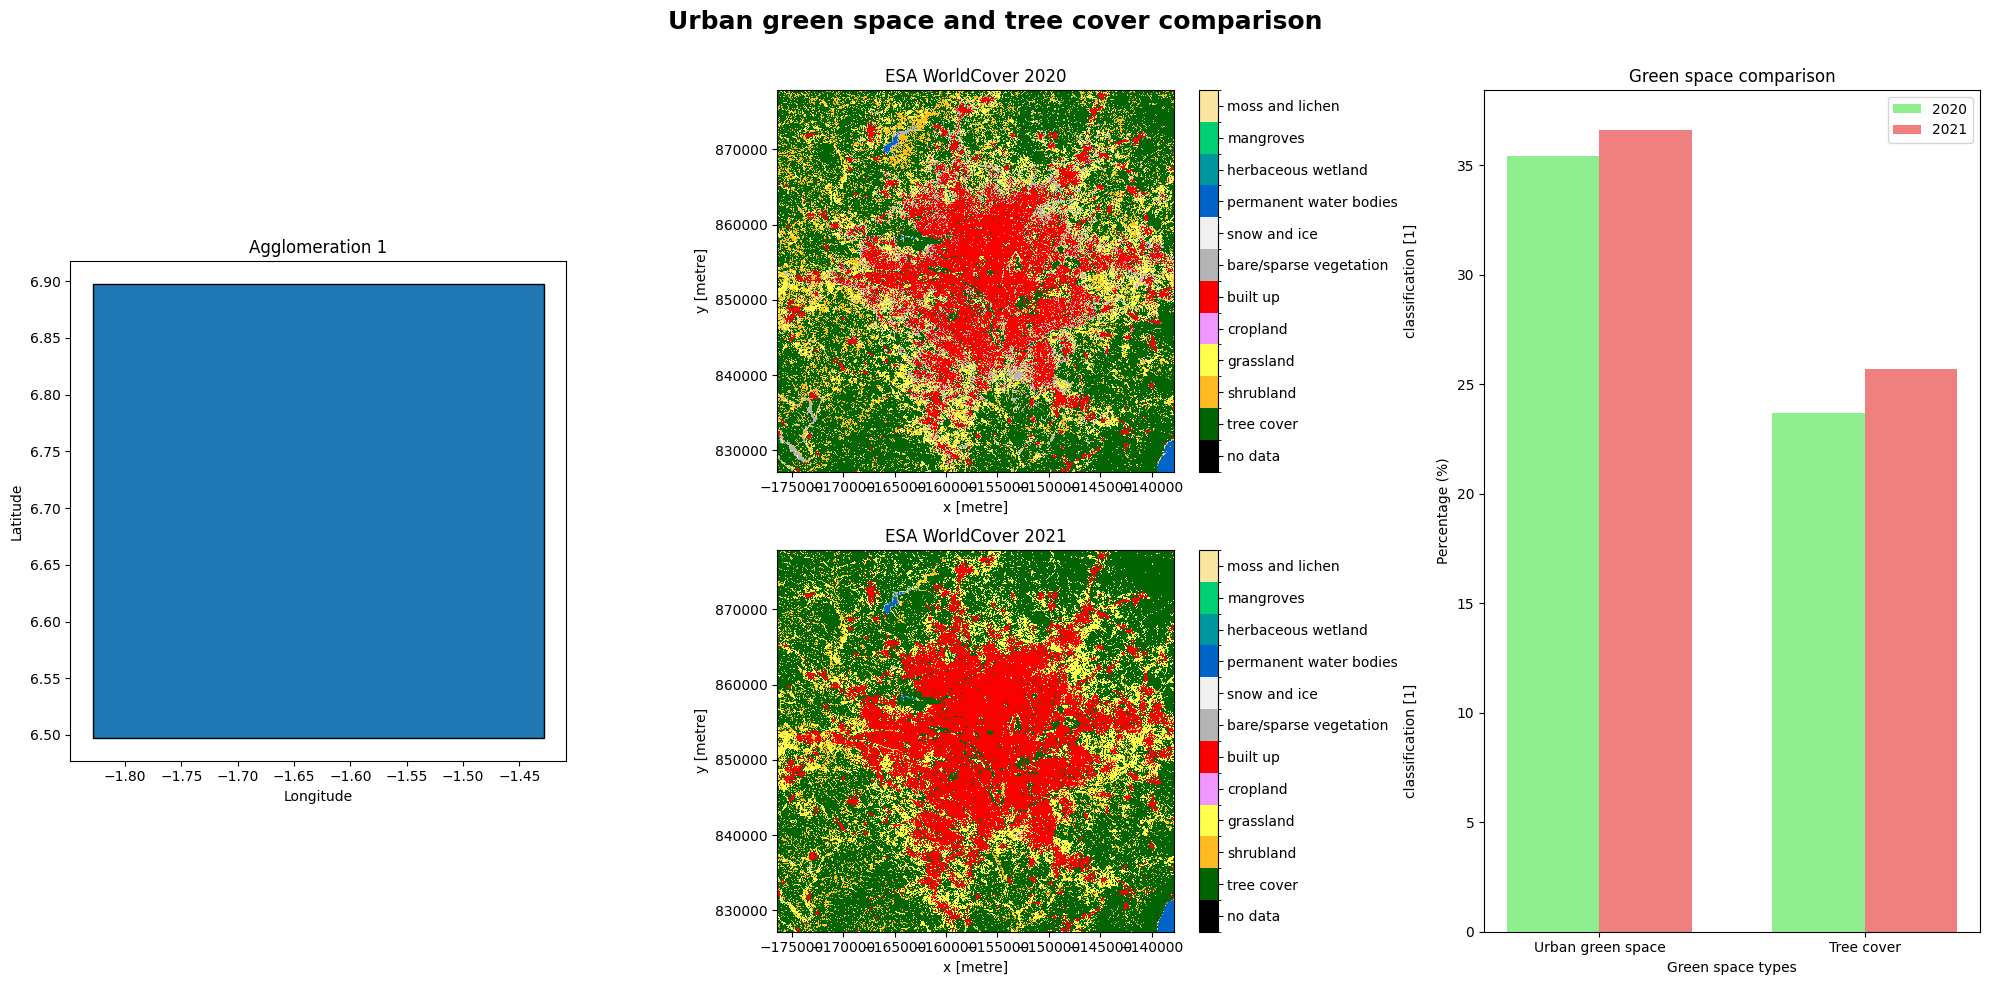

In [8]:
# Create a figure with dynamic subplots (3 columns: map, stacked WC, and bar)
num_agglomerations = len(green_space_indicators)
fig = plt.figure(figsize=(20, 10 * num_agglomerations))  # Set figure size

# Iterate over selected agglomerations and their corresponding subplot axes
for i, (index, agglomeration) in enumerate(green_space_indicators.iterrows()):
    # Subplot layout (3 columns: map, stacked WC, and bar)
    # Map subplot (spans 2 rows)
    ax_map = plt.subplot2grid((num_agglomerations * 2, 3), (i * 2, 0), rowspan=2) 
    # ESA WorldCover 2020 (top half of the second column)
    ax_wc_2020 = plt.subplot2grid((num_agglomerations * 2, 3), (i * 2, 1))  
    # ESA WorldCover 2021 (bottom half of the second column)
    ax_wc_2021 = plt.subplot2grid((num_agglomerations * 2, 3), (i * 2 + 1, 1))  
    # Bar chart subplot (spans 2 rows)
    ax_bar = plt.subplot2grid((num_agglomerations * 2, 3), (i * 2, 2), rowspan=2)
    # Extract the agglomeration as a GeoDataFrame
    agglomeration_gdf = green_space_indicators.iloc[i:i+1]

    # Plot the agglomeration polygon on the map axis
    ax_map.set_title(f"Agglomeration {agglomeration['agglosID']}") 
    agglomeration_gdf.plot(ax=ax_map, edgecolor='black')
    ax_map.set_xlabel("Longitude")
    ax_map.set_ylabel("Latitude")
    
    # Get the top-left corner of the bounding box
    bbox = agglomeration_gdf.total_bounds
    top_left_x, top_left_y = bbox[0], bbox[3]

    # Prepare data for the bar chart
    labels = ['Urban green space', 'Tree cover']
    wc2020 = [
        agglomeration['p_Urban_green_space_WC2020'],
        agglomeration['p_Tree_cover_WC2020']
    ]
    wc2021 = [
        agglomeration['p_Urban_green_space_WC2021'],
        agglomeration['p_Tree_cover_WC2021']
    ]
    
    # Plot grouped bar chart
    bar_width = 0.35
    index = np.arange(len(labels))  # Position of the bars on the x-axis
    ax_bar.bar(index - bar_width/2, wc2020, bar_width, label='2020', color='lightgreen')
    ax_bar.bar(index + bar_width/2, wc2021, bar_width, label='2021', color='lightcoral')
    
    # Add labels and title to the bar chart
    ax_bar.set_xlabel('Green space types')
    ax_bar.set_ylabel('Percentage (%)')
    ax_bar.set_title(f"Green space comparison")
    ax_bar.set_xticks(index)
    ax_bar.set_xticklabels(labels)
    ax_bar.legend()

    # Load ESA WorldCover Data for each agglomeration
    query = {
        'y': (agglomeration_gdf.total_bounds[1], agglomeration_gdf.total_bounds[3]),
        'x': (agglomeration_gdf.total_bounds[0], agglomeration_gdf.total_bounds[2]),
        'resolution': (10, -10),
        'output_crs': 'epsg:6933',
        'measurements': 'classification'
    }
    
    # Load ESA WorldCover data for both 2020 and 2021
    esa_wc = dc.load(product=['esa_worldcover_2020', 'esa_worldcover_2021'], **query).squeeze()

    # Rasterize the area of interest polygon for masking ESA WorldCover data
    aoi_raster = xr_rasterize(gdf=agglomeration_gdf, da=esa_wc, crs=esa_wc.crs)

    # Mask ESA WorldCover data based on the agglomeration boundary
    esa_wc_2020_masked = esa_wc.sel(time="2020").squeeze()['classification'].where(aoi_raster == 1)
    esa_wc_2021_masked = esa_wc.sel(time="2021").squeeze()['classification'].where(aoi_raster == 1)

    # Plot ESA WorldCover 2020 (top part of the stack)
    plot_lulc(esa_wc_2020_masked, product="ESA", legend=True, ax=ax_wc_2020)
    ax_wc_2020.set_title("ESA WorldCover 2020")
    
    # Plot ESA WorldCover 2021 (bottom part of the stack)
    plot_lulc(esa_wc_2021_masked, product="ESA", legend=True, ax=ax_wc_2021)
    ax_wc_2021.set_title("ESA WorldCover 2021")

# Add a title for the entire figure
fig.suptitle(f"Urban green space and tree cover comparison", fontsize=18, fontweight='bold')

# Adjust layout and show the plot
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()


---

## Additional information

<b> License </b> The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0).

Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

<b> Contact </b> If you need assistance, please post a question on the [DE Africa Slack channel](https://digitalearthafrica.slack.com/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).

If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

<b> Compatible datacube version </b>

In [9]:
print(datacube.__version__)

1.8.19


**Last Tested:**

In [10]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2025-01-28'